In [ ]:
# Importações essenciais
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow # Necessário para salvar em Parquet

# Configurações de visualização (opcional)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Carregue o dataset original e pegue uma amostra aleatória de 10.000 linhas
# NOTA: 72.5 MB (tamanho original [cite: 13]) deve carregar bem na memória
try:
    # Ajuste 'seu_dataset.csv' para o nome real do seu arquivo
    # Especifique o 'encoding' se tiver problemas com acentuação (ex: 'latin1' ou 'utf-8')
    df_full = pd.read_csv('pda-008-caracteristicas_produtos_saude_suplementar.csv', encoding='latin1', sep=';') # Ajuste o separador se necessário

    # Crie sua amostra de desenvolvimento
    df_raw = df_full.sample(n=10000, random_state=42) # random_state=42 garante reprodutibilidade

    print(f"Amostra de {len(df_raw)} registros carregada.")
except FileNotFoundError:
    print("Erro: Arquivo do dataset não encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Erro ao carregar o CSV: {e}")
    print("Verifique o 'encoding' (ex: 'utf-8', 'latin1') e o 'sep' (ex: ',', ';')")

# Ver a estrutura inicial
if 'df_raw' in locals():
    df_raw.info()

Amostra de 10000 registros carregada.
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 56252 to 37563
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID_PLANO               10000 non-null  int64 
 1   CD_PLANO               10000 non-null  object
 2   NM_PLANO               10000 non-null  object
 3   REGISTRO_OPERADORA     10000 non-null  int64 
 4   RAZAO_SOCIAL           10000 non-null  object
 5   GR_MODALIDADE          10000 non-null  object
 6   PORTE_OPERADORA        10000 non-null  object
 7   VIGENCIA_PLANO         10000 non-null  object
 8   CONTRATACAO            10000 non-null  object
 9   GR_CONTRATACAO         10000 non-null  object
 10  SGMT_ASSISTENCIAL      10000 non-null  object
 11  GR_SGMT_ASSISTENCIAL   10000 non-null  object
 12  LG_ODONTOLOGICO        10000 non-null  int64 
 13  OBSTETRICIA            10000 non-null  object
 14  COBERTURA              10000 non-

In [ ]:
# Crie uma conexão "em memória" com o DuckDB
con = duckdb.connect(database=':memory:')

# Registre o DataFrame 'df_raw' como uma tabela SQL chamada 'planos_raw'
if 'df_raw' in locals():
    con.register('planos_raw', df_raw)

Dados faltantes por coluna (Pandas):
ID_PLANO                    0
CD_PLANO                    0
NM_PLANO                    0
REGISTRO_OPERADORA          0
RAZAO_SOCIAL                0
GR_MODALIDADE               0
PORTE_OPERADORA             0
VIGENCIA_PLANO              0
CONTRATACAO                 0
GR_CONTRATACAO              0
SGMT_ASSISTENCIAL           0
GR_SGMT_ASSISTENCIAL        0
LG_ODONTOLOGICO             0
OBSTETRICIA                 0
COBERTURA                   0
TIPO_FINANCIAMENTO          0
ABRANGENCIA_COBERTURA       0
ID_GEO_COBERTURA         3753
FATOR_MODERADOR             0
ACOMODACAO_HOSPITALAR       0
LIVRE_ESCOLHA               0
SITUACAO_PLANO              0
DT_SITUACAO                 0
DT_REGISTRO_PLANO        2437
DT_ATUALIZACAO              0
dtype: int64


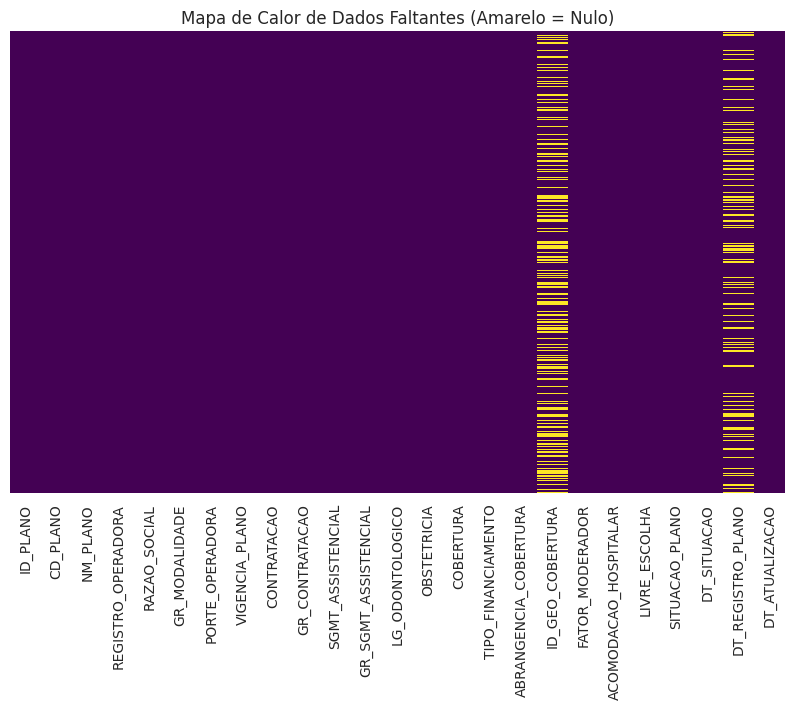

In [ ]:
# Verificação com Pandas
print("Dados faltantes por coluna (Pandas):")
print(df_raw.isnull().sum())

# Visualização de dados faltantes
plt.title('Mapa de Calor de Dados Faltantes (Amarelo = Nulo)')
sns.heatmap(df_raw.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.show()

In [ ]:
# Verifique a consistência da variável alvo
print("Valores únicos em 'SITUACAO_PLANO':")
print(con.execute("SELECT DISTINCT SITUACAO_PLANO FROM planos_raw").fetchdf())

# Verifique outras colunas-chave da sua hipótese
print("\nValores únicos em 'ABRANGENCIA_COBERTURA':")
print(con.execute("SELECT DISTINCT ABRANGENCIA_COBERTURA, COUNT(*) as total FROM planos_raw GROUP BY 1 ORDER BY 2 DESC").fetchdf())

print("\nValores únicos em 'CONTRATACAO':")
print(con.execute("SELECT DISTINCT CONTRATACAO, COUNT(*) as total FROM planos_raw GROUP BY 1 ORDER BY 2 DESC").fetchdf())

Valores únicos em 'SITUACAO_PLANO':
  SITUACAO_PLANO
0          Ativo
1       Suspenso
2      Cancelado
3    Transferido

Valores únicos em 'ABRANGENCIA_COBERTURA':
  ABRANGENCIA_COBERTURA  total
0  Grupo de municÃ­pios   5022
1              Nacional   2442
2             Municipal   1169
3              Estadual    846
4      Grupo de estados    372
5                Outras    149

Valores únicos em 'CONTRATACAO':
                                         CONTRATACAO  total
0                               Coletivo empresarial   4134
1                             Individual ou familiar   3241
2                               Coletivo por adesÃ£o   2044
3        Coletivo Empresarial + Coletivo por AdesÃ£o    374
4  Individual + Coletivo Empresarial + Coletivo p...    137
5      Individual ou Familiar + Coletivo por AdesÃ£o     39
6      Individual ou Familiar + Coletivo Empresarial     31


In [ ]:
if 'df_raw' in locals():
    df_clean = df_raw.copy()

    # 1. Padronização de Datas [cite: 121]
    # (Seu dataset tem 3 colunas de data )
    date_cols = ['DT_SITUACAO', 'DT_REGISTRO_PLANO', 'DT_ATUALIZACAO']
    for col in date_cols:
        # 'errors='coerce'' transforma datas inválidas em NaT (Nulo)
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

    print("Datas convertidas.")

    # 2. Tratamento de Inconsistências
    # Sua pergunta de pesquisa [cite: 26] foca em 'Ativo' ou 'Cancelado'.
    # Vamos simplificar a variável alvo.

    # Exemplo: Se 'SITUACAO_PLANO' tiver 'Ativo com comercialização suspensa' ou 'Suspenso',
    # podemos agrupá-los conforme a necessidade do problema.
    # Por agora, vamos focar apenas em 'Ativo' e 'Cancelado'.

    # Vamos criar uma coluna alvo binária (ou manter apenas os dois principais)
    # Aqui, vamos criar uma nova coluna 'TARGET' para manter o original
    # (Ou podemos filtrar, dependendo do objetivo)

    # Vamos normalizar a coluna SITUACAO_PLANO para "Ativo" ou "Cancelado"
    # (Assumindo que esses são os valores principais)
    df_clean['SITUACAO_PLANO'] = df_clean['SITUACAO_PLANO'].apply(
        lambda x: 'Ativo' if 'ATIVO' in str(x).upper() else ('Cancelado' if 'CANCELADO' in str(x).upper() else 'Outro')
    )

    # Vamos remover os 'Outro' para focar na classificação binária [cite: 26]
    df_clean = df_clean[df_clean['SITUACAO_PLANO'].isin(['Ativo', 'Cancelado'])].copy()

    print(f"Registros restantes após filtrar por 'Ativo'/'Cancelado': {len(df_clean)}")

    # 3. Tratamento de Dados Faltantes
    # Exemplo: Se 'ACOMODACAO HOSPITALAR' [cite: 15] for nulo, pode ser
    # porque o plano não é hospitalar. Vamos preencher com 'Não Aplicável'.
    if 'ACOMODACAO HOSPITALAR' in df_clean.columns:
        df_clean['ACOMODACAO HOSPITALAR'] = df_clean['ACOMODACAO HOSPITALAR'].fillna('Não Aplicável')

    # Para outras colunas categóricas, 'Desconhecido' é uma estratégia
    cols_to_fill = ['FATOR MODERADOR', 'TIPO FINANCIAMENTO', 'LIVRE_ESCOLHA']
    for col in cols_to_fill:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Desconhecido')

    # Para datas, se houver nulos após a coerção, talvez seja necessário
    # decidir se remove a linha ou imputa (ex: data mais antiga/recente)
    # Por agora, vamos remover linhas onde datas cruciais são nulas
    df_clean = df_clean.dropna(subset=['DT_REGISTRO_PLANO', 'DT_SITUACAO'])

    print("Tratamento de nulos concluído.")

    # 4. Validação Pós-Limpeza
    print("\nDados faltantes após limpeza:")
    print(df_clean.isnull().sum())

    print("\nValores da variável alvo após limpeza:")
    print(df_clean['SITUACAO_PLANO'].value_counts())

Datas convertidas.
Registros restantes após filtrar por 'Ativo'/'Cancelado': 5569
Tratamento de nulos concluído.

Dados faltantes após limpeza:
ID_PLANO                    0
CD_PLANO                    0
NM_PLANO                    0
REGISTRO_OPERADORA          0
RAZAO_SOCIAL                0
GR_MODALIDADE               0
PORTE_OPERADORA             0
VIGENCIA_PLANO              0
CONTRATACAO                 0
GR_CONTRATACAO              0
SGMT_ASSISTENCIAL           0
GR_SGMT_ASSISTENCIAL        0
LG_ODONTOLOGICO             0
OBSTETRICIA                 0
COBERTURA                   0
TIPO_FINANCIAMENTO          0
ABRANGENCIA_COBERTURA       0
ID_GEO_COBERTURA         1774
FATOR_MODERADOR             0
ACOMODACAO_HOSPITALAR       0
LIVRE_ESCOLHA               0
SITUACAO_PLANO              0
DT_SITUACAO                 0
DT_REGISTRO_PLANO           0
DT_ATUALIZACAO              0
dtype: int64

Valores da variável alvo após limpeza:
SITUACAO_PLANO
Cancelado    3174
Ativo        1708
Na

In [ ]:
# H1: Criar a 'idade do plano'
# Usamos a 'DT SITUACAO' como a "data atual" do registro
if 'df_clean' in locals():
    df_clean['IDADE_PLANO_DIAS'] = (df_clean['DT_SITUACAO'] - df_clean['DT_REGISTRO_PLANO']).dt.days

    # Se houver idades negativas (erro nos dados), trate-as (ex: como nulo ou 0)
    df_clean['IDADE_PLANO_DIAS'] = df_clean['IDADE_PLANO_DIAS'].apply(lambda x: max(x, 0))

    print("Feature 'IDADE_PLANO_DIAS' criada.")
    print(df_clean[['DT_REGISTRO_PLANO', 'DT_SITUACAO', 'IDADE_PLANO_DIAS']].head())

Feature 'IDADE_PLANO_DIAS' criada.
       DT_REGISTRO_PLANO DT_SITUACAO  IDADE_PLANO_DIAS
56252         2021-02-11  2021-02-11                 0
19351         2017-08-15  2017-08-15                 0
77861         1999-12-28  2006-08-24              2431
146335        1999-01-16  1999-08-23               219
141860        2023-07-26  2023-07-26                 0


In [ ]:
# Salve o dataset final limpo
if 'df_clean' in locals():
    try:
        df_clean.to_parquet('planos_saude_limpo.parquet', index=False, engine='pyarrow')
        print("\n--- Dataset limpo salvo com sucesso como 'planos_saude_limpo.parquet' ---")
    except Exception as e:
        print(f"Erro ao salvar o Parquet: {e}")


--- Dataset limpo salvo com sucesso como 'planos_saude_limpo.parquet' ---
